# Act Log Analysis

In [1]:
# imports
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy
from skimage import filters
from skimage import data
import seaborn as sns
from collections import Counter
from collections import defaultdict
import copy
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

In [2]:
# print and show what the entire dict looks like
def inspect_dict(d, level=0):
    """
    Recursively inspect a dictionary to determine its structure.
    
    Parameters:
    - d: Dictionary to inspect.
    - level: Current depth level (for nested dictionaries).
    """
    for key, value in d.items():
        indent = "  " * level  # Indentation for better readability
        if isinstance(value, dict):
            print(f"{indent}{key}: (Nested dictionary)")
            inspect_dict(value, level + 1)
        else:
            print(f"{indent}{key}: {type(value).__name__} (Value: {value})")

In [8]:
# Define the file paths
files = [
    '../../topk/base_auxt.pkl',
    '../../topk/maths.pkl',
    '../../topk/physics.pkl',
    '../../topk/philosophy.pkl',
    '../../topk/economics.pkl',
    '../../topk/medicine.pkl',
] 

# Load all files into a single dict
topk = {}

for file_path in files:
    with open(file_path, 'rb') as f:
        topk[file_path] = pickle.load(f)

In [9]:
econ = topk['../../topk/economics.pkl']

# print first key in econ
print(econ.keys())
print(len(econ['model.layers.0.mlp.gate_proj']['values']))

# get the number of all of the values stored in econ


dict_keys(['model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.act_fn', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.2.mlp.gate_proj', 'model.layers.2.mlp.act_fn', 'model.layers.2.mlp.up_proj', 'model.layers.2.mlp.down_proj', 'model.layers.3.mlp.gate_proj', 'model.layers.3.mlp.act_fn', 'model.layers.3.mlp.up_proj', 'model.layers.3.mlp.down_proj', 'model.layers.4.mlp.gate_proj', 'model.layers.4.mlp.act_fn', 'model.layers.4.mlp.up_proj', 'model.layers.4.mlp.down_proj', 'model.layers.5.mlp.gate_proj', 'model.layers.5.mlp.act_fn', 'model.layers.5.mlp.up_proj', 'model.layers.5.mlp.down_proj', 'model.layers.6.mlp.gate_proj', 'model.layers.6.mlp.act_fn', 'model.layers.6.mlp.up_proj', 'model.layers.6.mlp.down_proj', 'model.layers.7.mlp.gate_proj', 'model.layers.7.mlp.act_fn', 'model.layers.7.mlp.up_proj', 'model.layers.7.mlp.down_proj', 'mode

In [10]:
# step 1: show hsm1 for topk of 3,100, and 1000
# show all the nodes activated per layer as a graph

# remember to remove down for both for second section

# get the topk_act
def get_act_index(d,topk, mink = 0):
    act_index = []
    for layer_name, values in d.items():
        # removing down just because it has 4000 nodes per layer unlike the rest
        # if "30" not in layer_name and "31" not in layer_name:
        for name, val in values.items():
            if name == "indices":
                act_index.append(val[mink:topk])
    return act_index


# get the topk_act values
def get_act_values(d,topk, mink = 50):
    act_index = []
    for layer_name, values in d.items():
        # removing down just because it has 4000 nodes per layer unlike the rest
        # if "30" not in layer_name and "31" not in layer_name:
        for name, val in values.items():
            if name == "values":
                act_index.append(val[mink:topk])
    return act_index

# print the graph for the items
# need to make a heat color based on the order of it
def show_act_in_layers(data,color):
    for row_index, row in enumerate(data):
        x_values = [row_index] * len(row)  # X-axis is the row index
        y_values = row  # Y-axis is the row values
        plt.scatter(
            x_values, 
            y_values, 
            marker='.', 
            s=40, 
            alpha = 0.5,
            color=color,
            label=f"Row {row_index}"
        )

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [11]:
mink = 0

# load all the topk values
maths = topk['../../topk/maths.pkl']
act_index_maths = get_act_index(maths,1000, mink = mink)
act_values_maths = get_act_values(maths,1000, mink = mink)

physics = topk['../../topk/physics.pkl']
act_index_physics = get_act_index(physics,1000, mink = mink)
act_values_physics = get_act_values(physics,1000, mink = mink)

philosophy = topk['../../topk/philosophy.pkl']
act_index_philosophy = get_act_index(philosophy,1000, mink = mink)
act_values_philosophy = get_act_values(philosophy,1000, mink = mink)

economics = topk['../../topk/economics.pkl']
act_index_economics = get_act_index(economics,1000, mink = mink)
act_values_economics = get_act_values(economics,1000, mink = mink)

medicine = topk['../../topk/medicine.pkl']
act_index_medicine = get_act_index(medicine,1000, mink = mink)
act_values_medicine = get_act_values(medicine,1000, mink = mink)

auxt = topk['../../topk/base_auxt.pkl']
act_index_auxt = get_act_index(auxt,1000, mink = mink)
act_values_auxt = get_act_values(auxt,1000, mink = mink)

In [12]:
print (act_values_maths[0][0:10])

# [1.3037109375, 1.2802734375, 1.271484375, 1.2666015625, 1.25390625, 1.25390625, 1.2470703125, 1.244140625, 1.23828125, 1.236328125] 1 iter
# [3.08984375, 3.0546875, 3.03125, 3.02734375, 3.001953125, 2.994140625, 2.931640625, 2.9140625, 2.87109375, 2.865234375] 10 iter

[5057.67919921875, 4928.98388671875, 4923.63427734375, 4920.7060546875, 4914.05029296875, 4914.05029296875, 4857.17236328125, 4693.13818359375, 4644.62744140625, 4618.888671875]


In [13]:
# flatten 3d list
flattened_list = [item for sublist in act_values_maths for item in sublist]
 
# Find the maximum value
max_value = max(flattened_list)
min_value = min(flattened_list)

# Count how many times the maximum value appears
count_max = flattened_list.count(max_value)
count_min = flattened_list.count(min_value)

print(f"The maximum value is {max_value} and it appears {count_max} times out of {len(flattened_list)}, ({100*count_max/len(flattened_list)}%)")
print(f"The minimum value is {min_value} and it appears {count_min} times out of {len(flattened_list)}, ({100*count_min/len(flattened_list)}%)")

# 0.00078125%

The maximum value is 8191.97607421875 and it appears 91 times out of 128000, (0.07109375%)
The minimum value is 4095.988037109375 and it appears 25444 times out of 128000, (19.878125%)


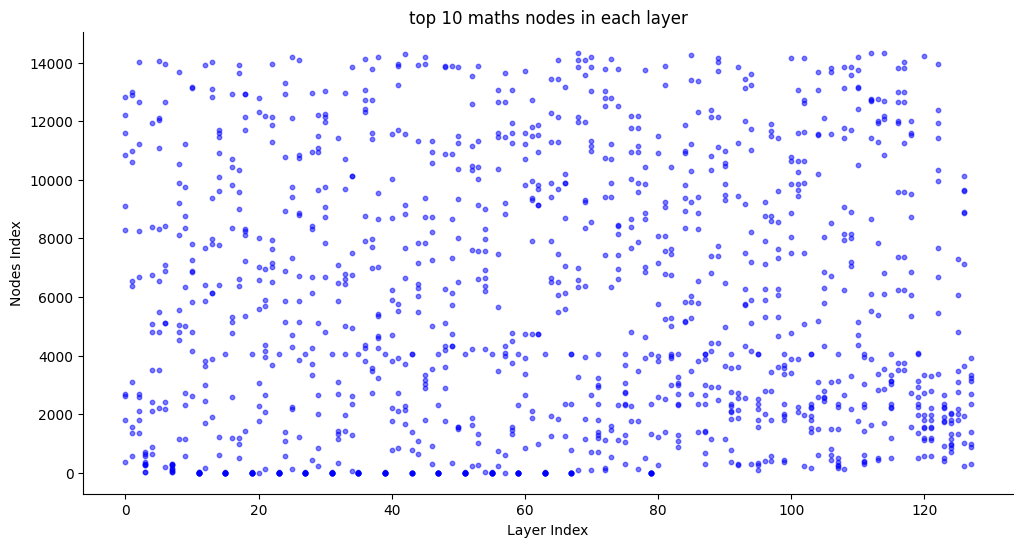

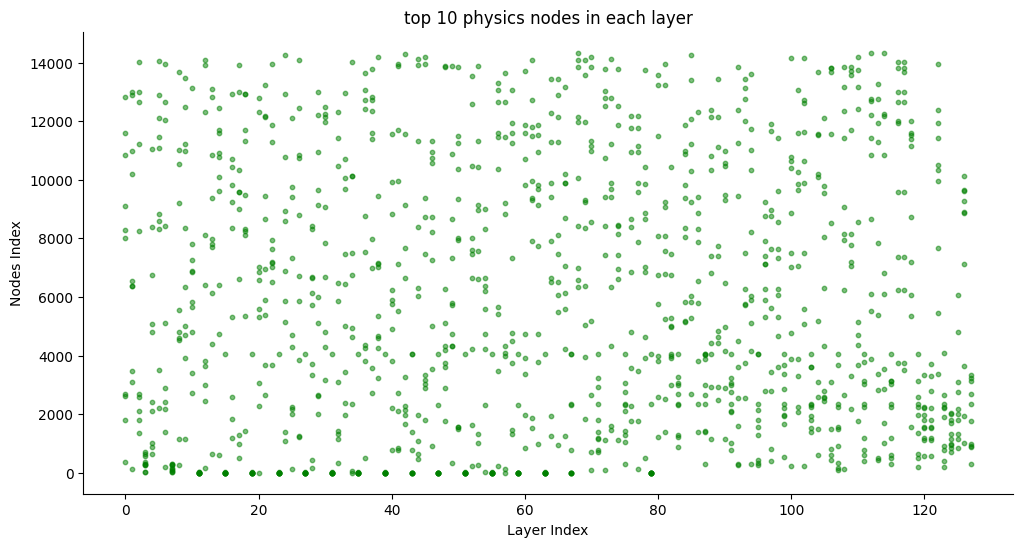

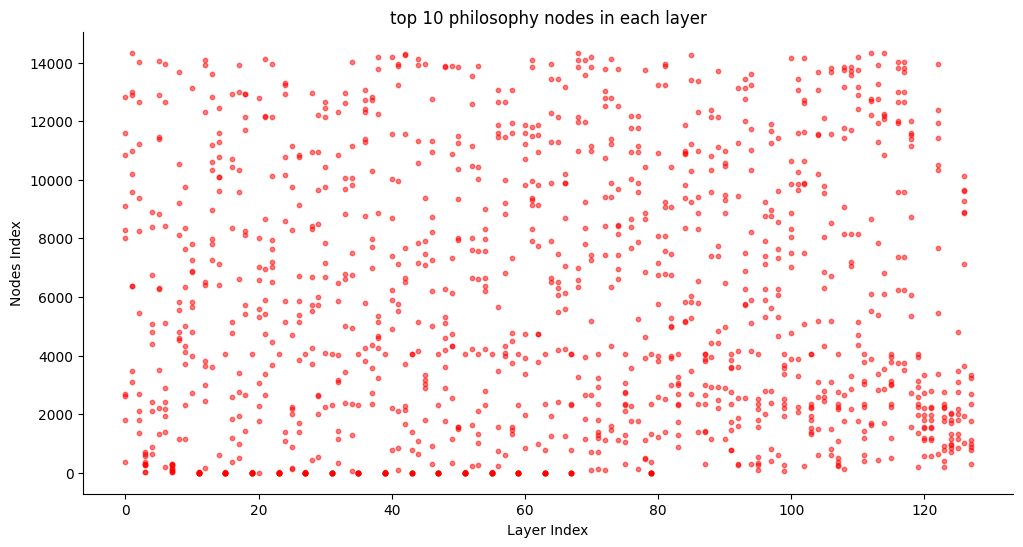

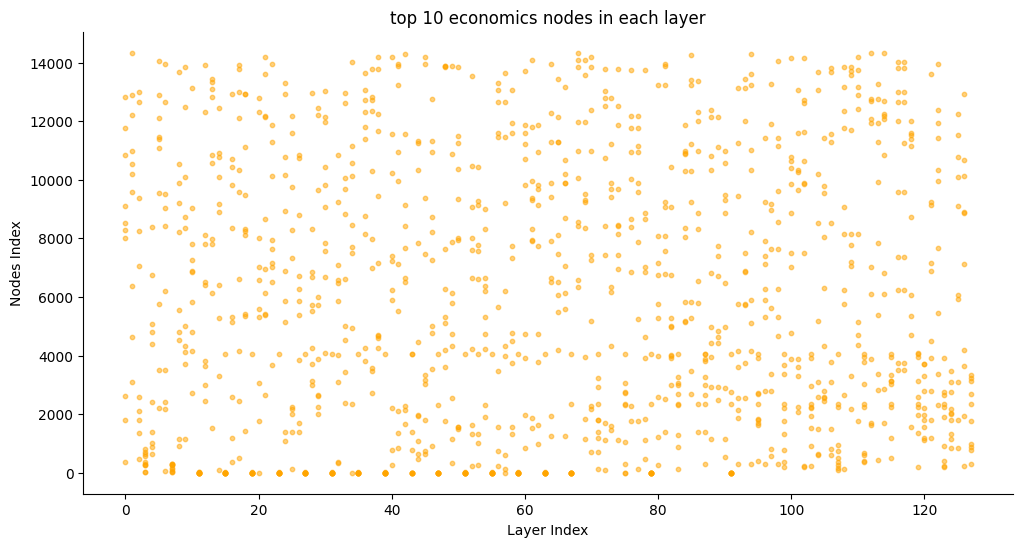

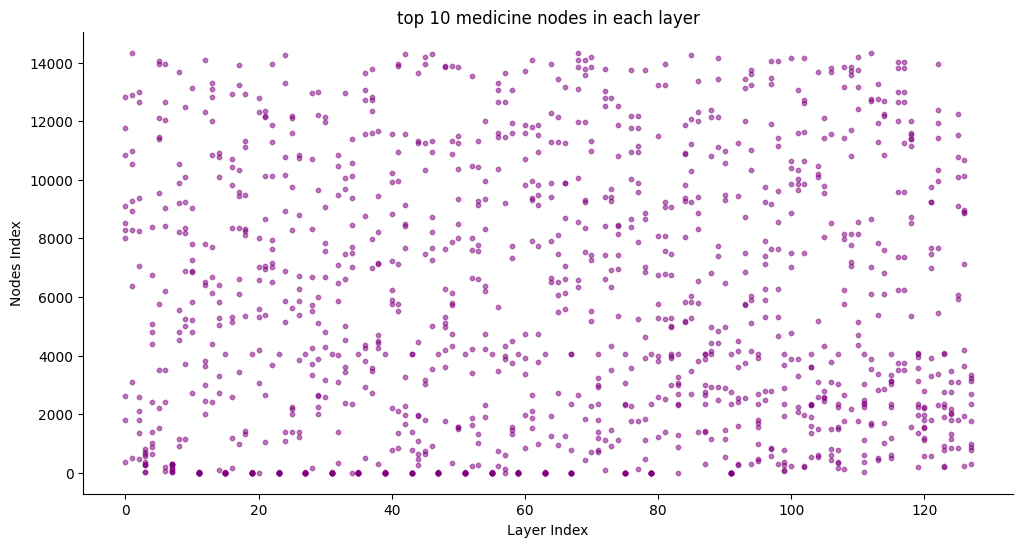

In [15]:
k = 10
mk = 0

act_index_mathsk = get_act_index(maths,k, mink = mk)
act_index_physicsk = get_act_index(physics,k, mink = mk)
act_index_philosophyk = get_act_index(philosophy,k, mink = mk)
act_index_medicinek = get_act_index(medicine,k, mink = mk)
act_index_economicsk = get_act_index(economics,k, mink = mk)
act_index_auxtk = get_act_index(auxt,k, mink = mk)

plt.figure(figsize=(12, 6))
show_act_in_layers(act_index_mathsk,"blue")
plt.xlabel("Layer Index")
plt.ylabel("Nodes Index")
plt.title("top 10 maths nodes in each layer")
plt.show()

plt.figure(figsize=(12, 6))
show_act_in_layers(act_index_physicsk,"green")
plt.xlabel("Layer Index")
plt.ylabel("Nodes Index")
plt.title("top 10 physics nodes in each layer")
plt.show()


plt.figure(figsize=(12, 6))
show_act_in_layers(act_index_philosophyk,"red")
plt.xlabel("Layer Index")
plt.ylabel("Nodes Index")
plt.title("top 10 philosophy nodes in each layer")
plt.show()

plt.figure(figsize=(12, 6))
show_act_in_layers(act_index_economicsk,"orange")
plt.xlabel("Layer Index")
plt.ylabel("Nodes Index")
plt.title("top 10 economics nodes in each layer")
plt.show()

plt.figure(figsize=(12, 6))
show_act_in_layers(act_index_medicinek,"purple")
plt.xlabel("Layer Index")
plt.ylabel("Nodes Index")
plt.title("top 10 medicine nodes in each layer")
plt.show()

total number of overlap    :  1041
total number of no overlap    :  239


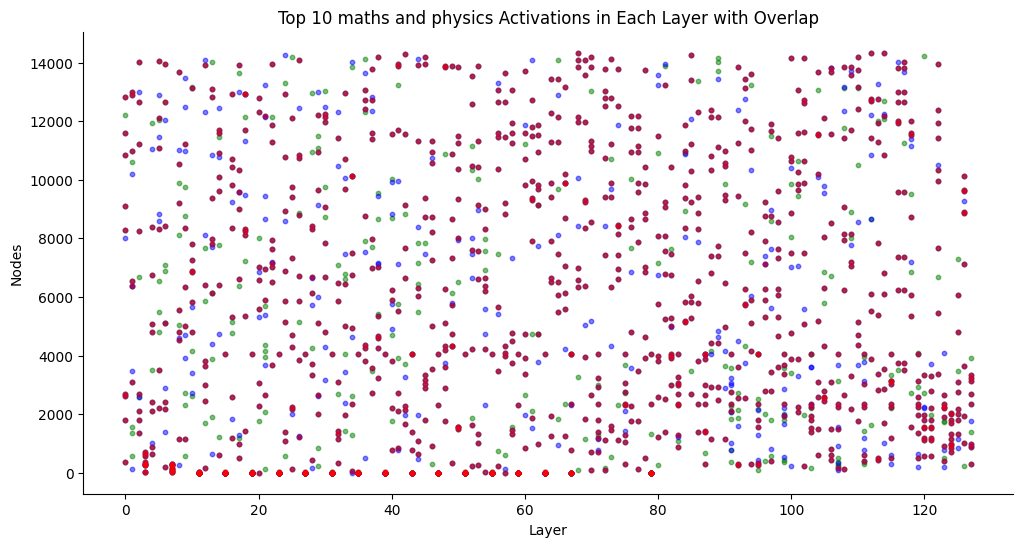

In [17]:
plt.figure(figsize=(12, 6))
# Plot maths activations
show_act_in_layers(act_index_mathsk, "green")
# Plot auxt activations
show_act_in_layers(act_index_physicsk, "blue")

# Calculate the overlap (intersection) between the two sets of node positions
overlap = []
count = 0
count_opp = 0
for layer in range(len(act_index_mathsk)):
    # Find common nodes between maths and physics for this layer
    common_nodes = set(act_index_mathsk[layer]).intersection(set(act_index_physicsk[layer]))
    opp_nodes = set(act_index_mathsk[layer]) ^ set(act_index_physicsk[layer])
    overlap.append(list(common_nodes))
    count += len(common_nodes)
    count_opp += len(opp_nodes)

print ("total number of overlap    : ", count)
# div 2 becuase it's going to double the amount of no overlap
print ("total number of no overlap    : ", int(count_opp / 2)) 

# Plot the overlap
show_act_in_layers(overlap, "red")

plt.xlabel("Layer")
plt.ylabel("Nodes")
plt.title("Top 10 maths and physics Activations in Each Layer with Overlap")
plt.show()

realised the up proj max for topk is 4000 and therefore is a much more dense layer, but for the rest of them, they all go up to 14k. May want to either play with that or turn it off in the future

In [18]:
# showing it as a heat image where the order dictates the heat of it per layer

def topk_act_to_img(data, data_name):
    data = np.array(data)
    struct_data = np.zeros((len(data), np.max(data)+1))
    
    # change list struct
    for i, ival in enumerate(data):
        for j, jval in enumerate(ival):
            struct_data[i][jval] = len(ival) -  int(j)

    # generate the image
    plt.figure(dpi = 200)
    plt.imshow(struct_data.T, vmin=50, vmax=255, aspect = 0.006, cmap = "viridis")
    plt.xlabel("Layer")
    plt.ylabel("Node index")
    plt.title("Top-k in each layer for {}".format(data_name))
    plt.show()

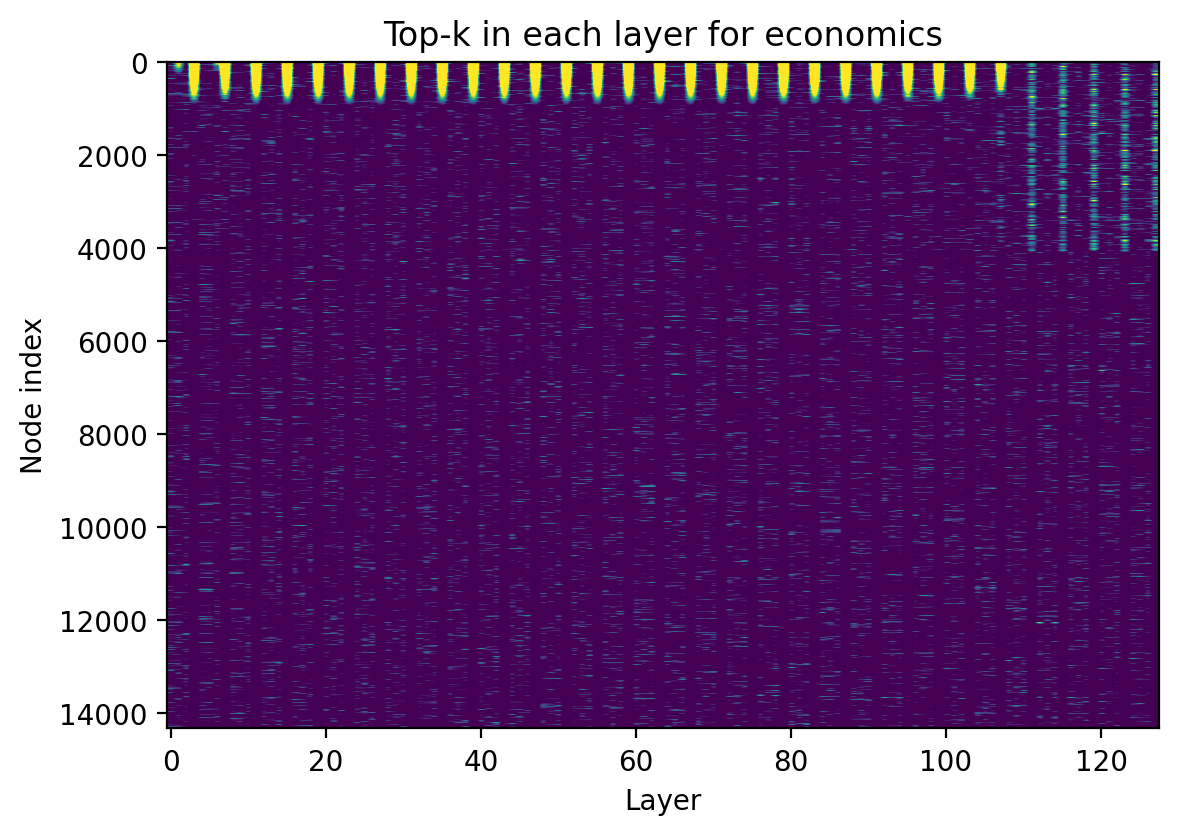

In [19]:
# always seeing a pitchfork, but it's literally my mind making that up
topk_act_to_img(act_index_economics, "economics")

In [20]:
# step 2: show the difference between hsm and hsm1
# show the deviation amount in scores between the 2

# showing the percentage change
def compare_act_logs(d1,d2,topk:int):
    total_matched = 0
    total = len(d1) * len(d1[0][:topk])

    for layer in range(len(d1)):
        common_nodes = set(d1[layer][:topk]).intersection(set(d2[layer][:topk]))
        total_matched += len(common_nodes)
    
    print ("total topk values: ", total)
    print ("total topk matched: ", total_matched)
    print ("percentage of topk matched: ", total_matched/total * 100,"%")

    return total_matched/total * 100


def subtract_act_logs(d1,d2):
    total = len(d1) * len(d1[0])
    print ("original total: ", total)

    d3 = copy.deepcopy(d1)
    
    total_subtracted = 0
    for i in range(len(d2)):
        for j in range(1000):
            if d1[i][j] in d2[i]:    
                d3[i][j] = None
                total_subtracted += 1

    print ("amount subtracted: ", total_subtracted)

    return d3

In [21]:
# step 3: show the topk of hsm and compare that to auxt and rand
# essentially showing that the activations are different to just random ones

# generate a random rand index
def gen_rand_act_index(data):
    row = len(data)
    col = len(data[0])

    max_val = max(map(max,data))

    print("max value: ",max_val)
    rand_data = np.random.randint(max_val,size = (row,col))

    for i in range(3, row, 4):
        rand_data[i] = np.random.randint(4097, size=col)

    return rand_data

# less entropy means that the data is less likely to be random (relative)
def rand_check(data, base_data):
    data = np.array(data)
    value_counts = np.bincount(data.flatten())
    entropy_value = scipy.stats.entropy(value_counts, base=2)
    
    base_data = np.array(base_data)
    base_value_counts = np.bincount(base_data.flatten())
    base_entropy_value = scipy.stats.entropy(base_value_counts, base=2)

    print(f"Entropy: {entropy_value}")
    print(f"Entropy relative to the base: {entropy_value/base_entropy_value}")

    return None

In [22]:
k = 50
act_index_ms_sub_auxt = subtract_act_logs(act_index_maths, act_index_auxt)
act_index_ps_sub_auxt = subtract_act_logs(act_index_physics, act_index_auxt)


print("\n maths sub and physics")
compare_act_logs(act_index_maths,act_index_physics,k)

print("\n maths sub and physics sub")
compare_act_logs(act_index_ms_sub_auxt,act_index_ps_sub_auxt,k)

original total:  128000
amount subtracted:  35333
original total:  128000
amount subtracted:  35653

 maths sub and physics
total topk values:  6400
total topk matched:  5226
percentage of topk matched:  81.65625 %

 maths sub and physics sub
total topk values:  6400
total topk matched:  2183
percentage of topk matched:  34.109375 %


34.109375

In [23]:
# sub aux
act_index_maths_sub_auxt = subtract_act_logs(act_index_maths, act_index_auxt)
act_index_physics_sub_auxt = subtract_act_logs(act_index_physics, act_index_auxt)
act_index_philosophy_sub_auxt = subtract_act_logs(act_index_philosophy, act_index_auxt)
act_index_economics_sub_auxt = subtract_act_logs(act_index_economics, act_index_auxt)
act_index_medicine_sub_auxt = subtract_act_logs(act_index_medicine, act_index_auxt)

# init rand
act_index_rand = gen_rand_act_index(act_index_auxt)

k = 1000

# subbing aux
print("\n maths sub and physics sub")
compare_act_logs(act_index_maths_sub_auxt,act_index_physics_sub_auxt,k)
print("\n maths sub and philosophy sub")
compare_act_logs(act_index_maths_sub_auxt,act_index_philosophy_sub_auxt,k)
print("\n physics sub and philosophy sub")
compare_act_logs(act_index_physics_sub_auxt,act_index_philosophy_sub_auxt,k)
print("\n maths sub and economics sub")
compare_act_logs(act_index_maths_sub_auxt,act_index_economics_sub_auxt,k)
print("\n physics sub and economics sub")
compare_act_logs(act_index_physics_sub_auxt,act_index_economics_sub_auxt,k)
print("\n philosophy sub and economics sub")
compare_act_logs(act_index_philosophy_sub_auxt,act_index_economics_sub_auxt,k)
print("\n maths sub and medicine sub")
compare_act_logs(act_index_maths_sub_auxt,act_index_medicine_sub_auxt,k)
print("\n physics sub and medicine sub")
compare_act_logs(act_index_physics_sub_auxt,act_index_medicine_sub_auxt,k)
print("\n philosophy sub and medicine sub")
compare_act_logs(act_index_philosophy_sub_auxt,act_index_medicine_sub_auxt,k)
print("\n economics sub and medicine sub")
compare_act_logs(act_index_economics_sub_auxt,act_index_medicine_sub_auxt,k)

# no sub
print("\n maths and physics")
compare_act_logs(act_index_physics, act_index_maths, k)
print("\n maths and philosophy")
compare_act_logs(act_index_philosophy, act_index_maths, k)
print("\n physics and philosophy")
compare_act_logs(act_index_philosophy, act_index_physics, k)
print("\n maths and auxt")
compare_act_logs(act_index_maths, act_index_auxt, k)
print("\n physics and auxt")
compare_act_logs(act_index_physics, act_index_auxt, k)
print("\n philosophy and auxt")
compare_act_logs(act_index_philosophy, act_index_auxt, k)
print("\n economics and auxt")
compare_act_logs(act_index_economics, act_index_auxt, k)
print("\n medicine and auxt")
compare_act_logs(act_index_medicine, act_index_auxt, k)


# random checks
print("\n")
print("For the random checks")
print("\n")
compare_act_logs(act_index_maths, act_index_rand, k)
print("\n")
compare_act_logs(act_index_physics, act_index_rand, k)
print("\n")
compare_act_logs(act_index_philosophy, act_index_rand, k)
print("\n")
compare_act_logs(act_index_auxt, act_index_rand, k)
print("\n")
compare_act_logs(act_index_economics, act_index_rand, k)
print("\n")
compare_act_logs(act_index_medicine, act_index_rand, k)
print("\n")

original total:  128000
amount subtracted:  35333
original total:  128000
amount subtracted:  35653
original total:  128000
amount subtracted:  35441
original total:  128000
amount subtracted:  34190
original total:  128000
amount subtracted:  34269
max value:  14335

 maths sub and physics sub
total topk values:  128000
total topk matched:  73355
percentage of topk matched:  57.30859375 %

 maths sub and philosophy sub
total topk values:  128000
total topk matched:  74728
percentage of topk matched:  58.381249999999994 %

 physics sub and philosophy sub
total topk values:  128000
total topk matched:  73070
percentage of topk matched:  57.08593749999999 %

 maths sub and economics sub
total topk values:  128000
total topk matched:  68175
percentage of topk matched:  53.26171875 %

 physics sub and economics sub
total topk values:  128000
total topk matched:  71769
percentage of topk matched:  56.069531250000004 %

 philosophy sub and economics sub
total topk values:  128000
total topk 

In [37]:
# plot line graph of correlation between math sub and physics sub from k = 1 to 1000

def get_correlation(d1,d2):
    corr = []
    for k in range(1,1001):
        corr.append(compare_act_logs(d1,d2,k))
    return corr

def plot_correlation(corr):
    x = np.arange(1,1001)
    y = corr
    plt.plot(x,y, color = "blue", alpha = 0.5)
    plt.xlabel("Top-k")
    plt.ylabel("Percentage of top-k matched")

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

In [18]:
corr = get_correlation(act_index_maths_sub_auxt, act_index_physics_sub_auxt)


total topk values:  128
total topk matched:  128
percentage of topk matched:  100.0 %
total topk values:  256
total topk matched:  138
percentage of topk matched:  53.90625 %
total topk values:  384
total topk matched:  144
percentage of topk matched:  37.5 %
total topk values:  512
total topk matched:  152
percentage of topk matched:  29.6875 %
total topk values:  640
total topk matched:  163
percentage of topk matched:  25.46875 %
total topk values:  768
total topk matched:  175
percentage of topk matched:  22.786458333333336 %
total topk values:  896
total topk matched:  182
percentage of topk matched:  20.3125 %
total topk values:  1024
total topk matched:  187
percentage of topk matched:  18.26171875 %
total topk values:  1152
total topk matched:  194
percentage of topk matched:  16.84027777777778 %
total topk values:  1280
total topk matched:  205
percentage of topk matched:  16.015625 %
total topk values:  1408
total topk matched:  220
percentage of topk matched:  15.625 %
total

In [33]:
corr_wo_sub = get_correlation(act_index_maths, act_index_physics)

total topk values:  128
total topk matched:  112
percentage of topk matched:  87.5 %
total topk values:  256
total topk matched:  221
percentage of topk matched:  86.328125 %
total topk values:  384
total topk matched:  330
percentage of topk matched:  85.9375 %
total topk values:  512
total topk matched:  428
percentage of topk matched:  83.59375 %
total topk values:  640
total topk matched:  533
percentage of topk matched:  83.28125 %
total topk values:  768
total topk matched:  634
percentage of topk matched:  82.55208333333334 %
total topk values:  896
total topk matched:  730
percentage of topk matched:  81.47321428571429 %
total topk values:  1024
total topk matched:  831
percentage of topk matched:  81.15234375 %
total topk values:  1152
total topk matched:  932
percentage of topk matched:  80.90277777777779 %
total topk values:  1280
total topk matched:  1029
percentage of topk matched:  80.390625 %
total topk values:  1408
total topk matched:  1133
percentage of topk matched: 

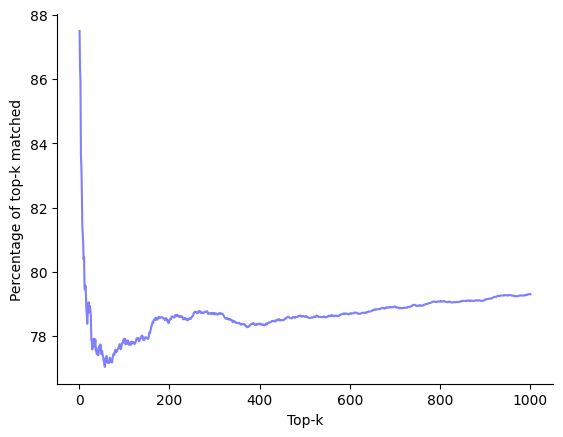

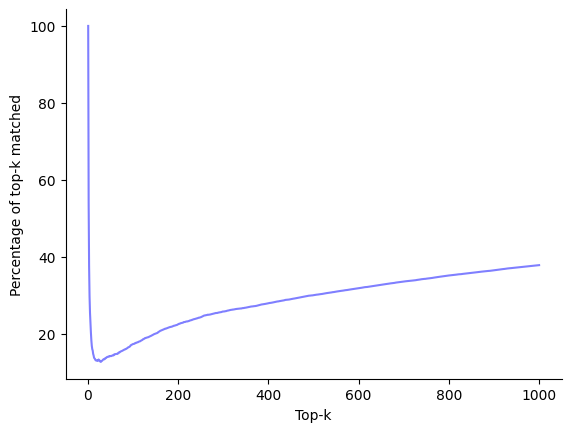

In [38]:
plot_correlation(corr_wo_sub)

plot_correlation(corr)

In [21]:
rand_check(act_index_rand, act_index_auxt)
rand_check(act_index_physics, act_index_auxt)
rand_check(act_index_maths, act_index_auxt)

Entropy: 13.724727283932282
Entropy relative to the base: 1.0098662448235447
Entropy: 13.577673454381326
Entropy relative to the base: 0.9990460153527994
Entropy: 13.578205236981368
Entropy relative to the base: 0.9990851439479443


analyse layer activation

In [16]:
def get_topk_global(matrix, index, k = 3):
    index = np.array(index)
    matrix = np.array(matrix)
    flattened = matrix.flatten()

    flattened_indices = np.argpartition(flattened, -k)[-k:]

    flattened_indices_sorted = flattened_indices[np.argsort(flattened[flattened_indices])]

    top_k_elements = flattened[flattened_indices_sorted]

    row_indices, col_indices = np.unravel_index(flattened_indices_sorted, matrix.shape)

    top_k_indices = list(zip(row_indices, col_indices))

    col_val = [index[row, col] for row, col in top_k_indices]

    return  row_indices, col_val

# get proportion of the amount of topk per layer
def get_topk_global_prop(rows, cols):
    coordinates = list(zip(rows,cols))
    row_counts = defaultdict(int)
    for row, col in coordinates:
        row_counts[row] += 1

    total_coordinates = len(coordinates)
    row_proportions = {row: count / total_coordinates for row, count in row_counts.items()}

    rows = list(row_proportions.keys())
    proportions = list(row_proportions.values())

    plt.bar(rows, proportions, color='blue', edgecolor='black')

    plt.xlabel('Row Index')
    plt.ylabel('Proportion')
    plt.title('Proportion of Indexes per Row')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.yscale('log')  # Add this line
    plt.show()



def show_topk_global(rows, cols, name):
    plt.figure(figsize=(12, 6))
    plt.scatter(rows,cols, c='blue',marker = '.', s=40, alpha = 0.5, label='Top-k Nodes')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel("Layer Index")
    plt.ylabel("Nodes Index")
    plt.title(f"global top 1000 nodes activated for {name}")

In [17]:
tkgms_rows, tkgms_cols = get_topk_global(act_values_maths_sparse, act_index_maths, k = 1000)
tkgps_rows, tkgps_cols = get_topk_global(act_values_physics_sparse, act_index_physics, k = 1000)
tkgphil_rows, tkgphil_cols = get_topk_global(act_values_philosophy_sparse, act_index_philosophy, k = 1000)

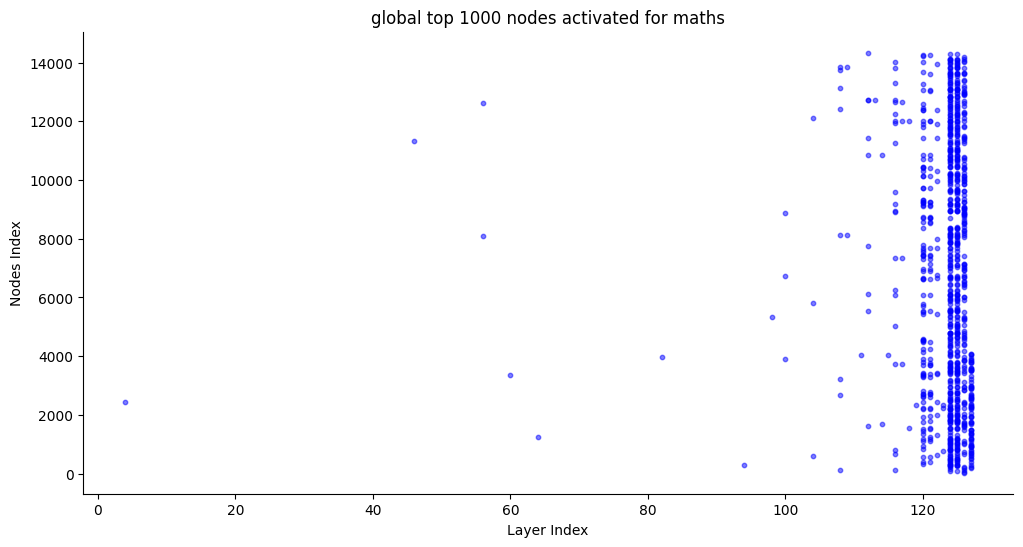

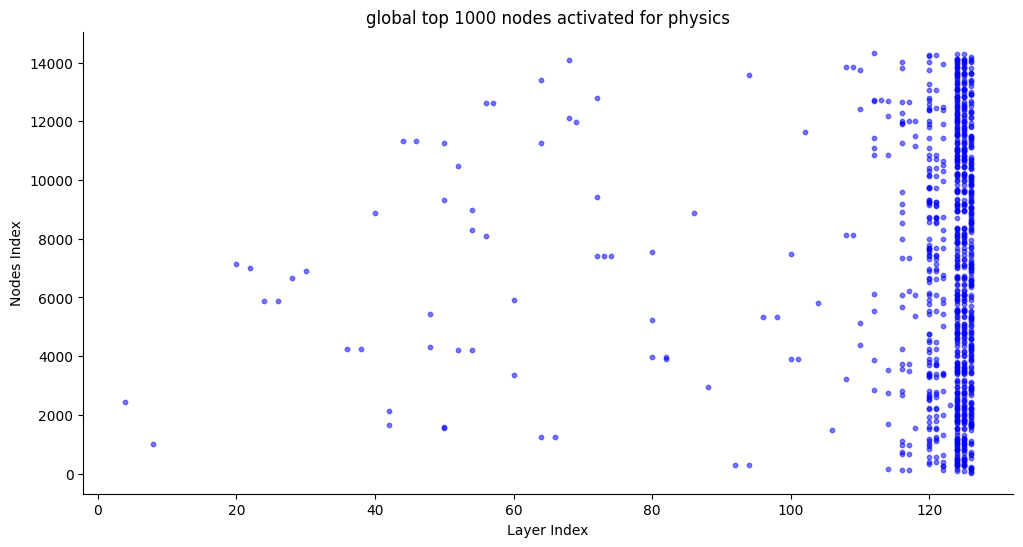

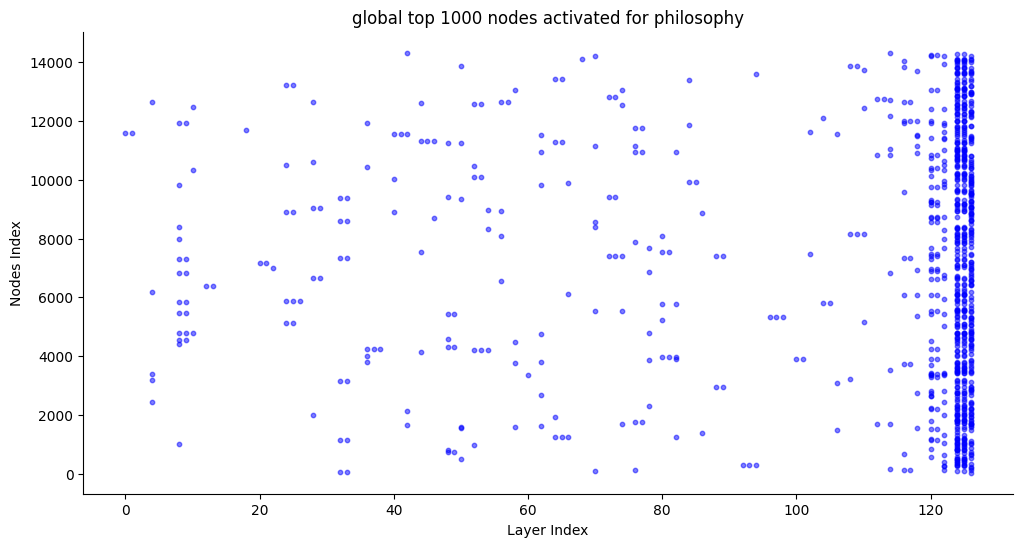

In [18]:
show_topk_global(tkgms_rows, tkgms_cols, "maths")
show_topk_global(tkgps_rows, tkgps_cols, "physics")
show_topk_global(tkgphil_rows, tkgphil_cols, "philosophy")

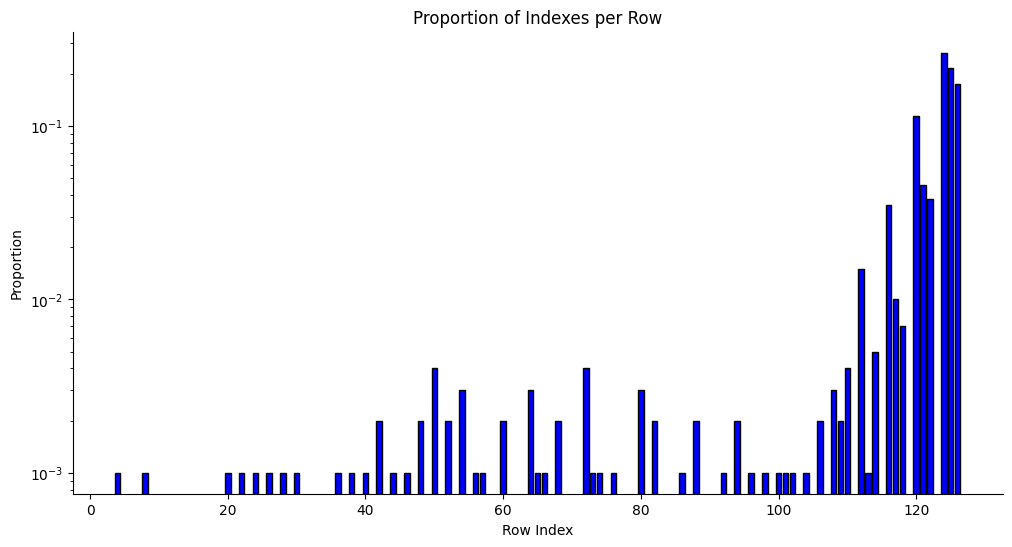

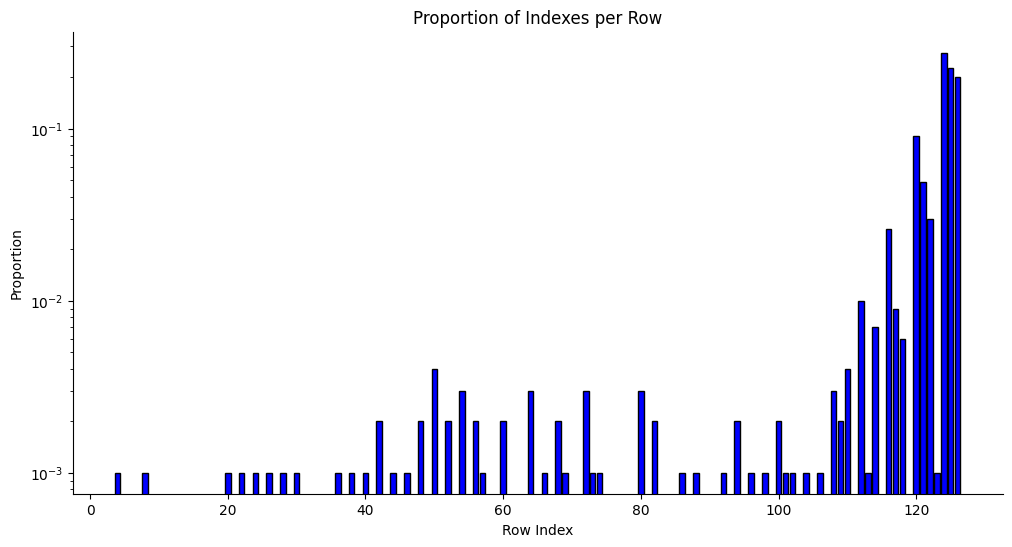

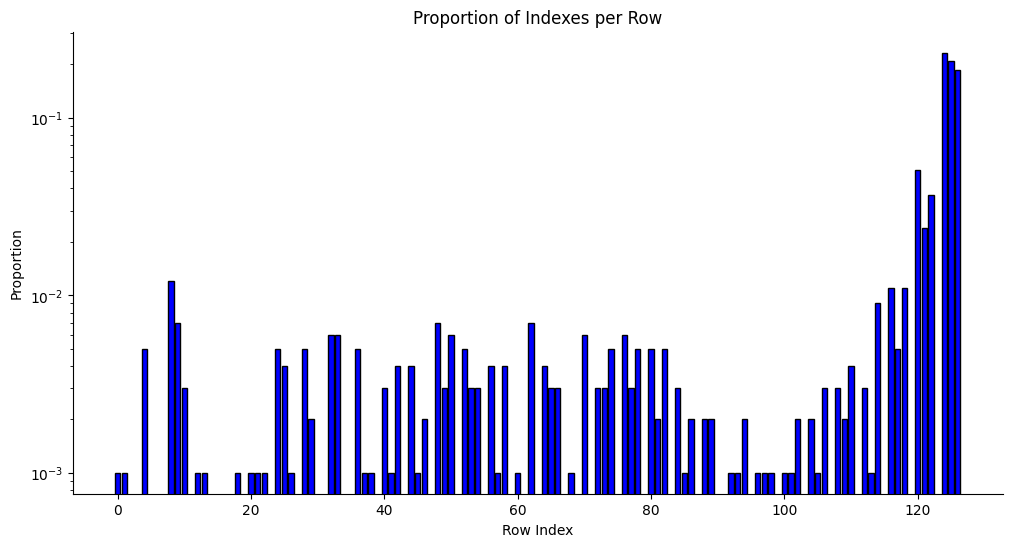

In [ ]:
plt.figure(figsize=(12, 6))
get_topk_global_prop(tkgms_rows, tkgms_cols)
plt.figure(figsize=(12, 6))
get_topk_global_prop(tkgps_rows, tkgps_cols)
plt.figure(figsize=(12, 6))
get_topk_global_prop(tkgphil_rows, tkgphil_cols)